In [1]:
import pandas as pd
import numpy as np

# 한글 폰트 깨짐 방지
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

#에러 무시
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

from sklearn.tree import export_graphviz
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import scale, minmax_scale, robust_scale

import xgboost as xgb

import seaborn as sns

plt.rcParams['font.family'] = 'NanumGothic'

In [2]:
# 속도와 각도 선형관계 있는 공식 찾기
# 찾은 후, 그 수치가 일정 수준 넘어가면 배럴이라는 것을 정의해야 함

In [2]:
hts = pd.read_csv('hts.csv', encoding = 'CP949')

## 전처리
- 번트는 타격이 아니고 가져다 대는 것이므로 삭제
- 안타여부와 장타여부 표시
 - 안타는 1
 - 장타는 1루타 : 1 / 2루타 : 2 / 3루타 : 3 / 홈런 : 4

In [3]:
# 번트는 팀 직전 타구이기 때문에 삭제

hts = hts.loc[(hts['타격결과'] != '번트안타')&
       (hts['타격결과'] != '번트아웃')&
       (hts['타격결과'] != '희생번트')]
hts.reset_index(drop = True, inplace = True)

# 안타 여부 표시
hts['안타여부'] = 0
hts['장타여부'] = 0

# 안타가 된 타구만 1로 
hts['안타여부'][(hts['타격결과'] == '1루타')] = 1
hts['안타여부'][(hts['타격결과'] == '2루타')] = 1
hts['안타여부'][(hts['타격결과'] == '3루타')] = 1
hts['안타여부'][(hts['타격결과'] == '홈런')] = 1
hts['안타여부'][(hts['타격결과'] == '직선타')] = 1 # 직선타를 안타로 설정

# 장타가 된 타구
hts['장타여부'][(hts['타격결과'] == '1루타')] = 1
hts['안타여부'][(hts['타격결과'] == '내야안타(1루타)')] = 1
hts['장타여부'][(hts['타격결과'] == '2루타')] = 2
hts['장타여부'][(hts['타격결과'] == '3루타')] = 3
hts['장타여부'][(hts['타격결과'] == '홈런')] = 4

In [4]:
hts = hts[['경기코드', '선수코드', '이닝', '타구속도', '발사각도', '타격결과', '안타여부', '장타여부']]

In [69]:
# # 이상치 제거
# # 함수 정의
# def outlier(df, column):   
    
#     Q1 = np.quantile(df[column], 0.25)
#     Q3 = np.quantile(df[column], 0.75)   
#     IQR = Q3 - Q1               
#     minimum = Q1 - (IQR * 1.5)
#     maximum = Q3 + (IQR * 1.5)
#     print('---------', column, '의 이상치---------')
#     print('IQR :',IQR)     
#     print('minimum :', minimum)     
#     print('maximum :', maximum)
    
#     NumOfOutlier = df[(df[column] > maximum) | (df[column] < minimum)].shape[0]
#     print('upper bound 이상치 개수 : ', df[df[column] > maximum].shape[0])
#     print('lower bound 이상치 개수 : ', df[df[column] < minimum].shape[0])
#     print('총 이상치 개수 : ', NumOfOutlier)

In [70]:
# outlier(hts, '타구속도')

In [71]:
# outlier(hts, '발사각도')

In [72]:
# hts = hts[(hts['타구속도'] > 80.34499999999997) & (hts['타구속도'] < 191.02500000000003)]
# hts = hts[(hts['발사각도'] > -51.800000000000004) & (hts['발사각도'] < 82.60000000000001)]

In [5]:
hts = hts.reset_index(drop = True)

In [6]:
hts

,경기코드,선수코드,이닝,타구속도,발사각도,타격결과,안타여부,장타여부
0,20180324HHWO0,62797,1,131.50,42.7,플라이,0,0
1,20180324HHWO0,76753,1,135.18,9.9,1루타,1,1
2,20180324HHWO0,71752,1,152.41,2.1,1루타,1,1
3,20180324HHWO0,62700,1,113.72,13.5,1루타,1,1
4,20180324HHWO0,78288,2,161.90,3.5,1루타,1,1
...,...,...,...,...,...,...,...,...
120409,20210711LTSS0,50458,8,141.23,-4.9,땅볼아웃,0,0
120410,20210711LTSS0,62415,8,101.09,31.8,1루타,1,1
120411,20210711LTSS0,75566,8,146.84,33.4,홈런,1,4
120412,20210711LTSS0,69418,8,146.12,23.9,홈런,1,4


In [75]:
# hts2 = hts

## 안타 여부
 - 안타 여부 col의 0, 1을 기준으로
  - hts_hit, hts_nonhit 두 가지로 구분

In [7]:
# 안타가 된 타구만 추출
hts_hit = hts.loc[(hts['안타여부'] == 1)]

# 안타가 되지 않은 타구 추출
hts_nonhit = hts.loc[(hts['안타여부'] == 0)]

In [8]:
hts_hit = hts_hit[['타구속도', '발사각도', '타격결과', '장타여부']]
hts_nonhit = hts_nonhit[['타구속도', '발사각도', '타격결과', '장타여부']]

In [9]:
hts_hit.reset_index(drop = True, inplace = True)
hts_nonhit.reset_index(drop = True, inplace = True)

In [10]:
hts_hit_except_single = hts_hit.loc[(hts_hit['타격결과'] == '2루타') |
           (hts_hit['타격결과'] == '3루타')|
#            (hts_hit['타격결과'] == '직선타') |
           (hts_hit['타격결과'] == '홈런')]

- 직선타 제외하고 2루타, 3루타, 홈런(잘 맞은타구)의 발사 각도 평균이 21.01도가 나옴

In [11]:
hts_hit_except_single['발사각도'].mean()

21.017424354243538

- 발사각도 최소값은 -68.1

In [12]:
hts['발사각도'].min()

-68.1

## 파생변수 생성

- 가정 -
 - 타구 속도는 높으면 높을 수록 좋음
 - 각도는 높으면 높을 수록 좋은게 아님 : 각도는 잘 맞은 타구의 각도의 일정 범위의 각도가 좋은 각도임
 - 위의 잘 맞은 타구(2루타, 3루타, 홈런)의 발사 각도 약 21.01도가 좋은 각도라고 가정
 - 그래서 공식으로
   - $100 - |잘 맞은 각도 - x|$
    - 예시
     - 1. 발사각도 23도의 홈런 : $100- |21 - 23| = 98$
     - 2. 발사각도 50의 플라이 아웃 : $100 - |21 - 50| = 71$  
     - 3. 발사각도 -23도의 땅볼 아웃 : $100 - |21 - (-23)| = 56$  
      => 각도가 21(최적의 각도)에서 음의 방향이거나 양의 방향으로 멀어질 수록 점수가 낮아짐

In [13]:
hts_pasaeng = hts

In [14]:
#                              100 - |21.022~(최적의 각도) -          x            |
hts_pasaeng['파생_발사각도'] = 100 - abs(21.02284237726097 - hts_pasaeng['발사각도'])

In [15]:
hts_pasaeng.groupby('타격결과')['파생_발사각도'].agg('mean').sort_values()

타격결과
파울플라이        52.051079
인필드플라이       57.246407
삼중살타         65.327158
야수선택         70.732927
땅볼아웃         71.196094
병살타          71.790145
내야안타(1루타)    73.855627
플라이          81.246353
1루타          85.190721
희생플라이        87.848240
직선타          88.290959
2루타          91.675335
홈런           92.046679
3루타          92.231953
Name: 파생_발사각도, dtype: float64

## 표준화
 - 타구속도는 대부분 140~180의 범위
 - 파생_발사각도는 최대값이 100이므로 minmax 표준화

In [16]:
df_num = hts_pasaeng[['타구속도', '파생_발사각도']]

In [17]:
# df_scale_minmax = minmax_scale(df_num)
# df_scale_minmax = pd.DataFrame(df_scale_minmax, columns = df_num.columns)
# df_scale_minmax

df_scale_robust = robust_scale(df_num)
df_scale_robust = pd.DataFrame(df_scale_robust, columns = df_num.columns)
df_scale_robust

,타구속도,파생_발사각도
0,-0.226599,-0.177340
1,-0.093603,0.342577
2,0.529093,-0.041659
3,-0.869172,0.519917
4,0.872064,0.027306
...,...,...
120409,0.125045,-0.386487
120410,-1.325623,0.359606
120411,0.327792,0.280788
120412,0.301771,0.748768


In [18]:
# hts_pasaeng['표준화_속도'] = df_scale_minmax['타구속도']
# hts_pasaeng['표준화_각도'] = df_scale_minmax['파생_발사각도']

hts_pasaeng['표준화_속도'] = df_scale_robust['타구속도']
hts_pasaeng['표준화_각도'] = df_scale_robust['파생_발사각도']

In [19]:
# hts_pasaeng['파생변수'] = hts_pasaeng['타구속도'] * hts_pasaeng['파생_발사각도']
# hts_pasaeng['표준화_파생변수'] = hts_pasaeng['표준화_속도'] + hts_pasaeng['표준화_각도']

hts_pasaeng['파생변수'] = hts_pasaeng['타구속도'] + hts_pasaeng['파생_발사각도']
hts_pasaeng['표준화_파생변수'] = hts_pasaeng['표준화_속도'] + hts_pasaeng['표준화_각도']

In [20]:
hts_pasaeng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120414 entries, 0 to 120413
Data columns (total 13 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   경기코드      120414 non-null  object 
 1   선수코드      120414 non-null  int64  
 2   이닝        120414 non-null  int64  
 3   타구속도      120414 non-null  float64
 4   발사각도      120414 non-null  float64
 5   타격결과      120414 non-null  object 
 6   안타여부      120414 non-null  int64  
 7   장타여부      120414 non-null  int64  
 8   파생_발사각도   120414 non-null  float64
 9   표준화_속도    120414 non-null  float64
 10  표준화_각도    120414 non-null  float64
 11  파생변수      120414 non-null  float64
 12  표준화_파생변수  120414 non-null  float64
dtypes: float64(7), int64(4), object(2)
memory usage: 11.9+ MB


- 타구속도 * '파생_발사각도 결과와 표준화된 col들을 더한 결과의 순서가 잘 맞은 타구가 높게 나오는 것을 볼 수 있음/

In [21]:
hts_pasaeng.groupby('타격결과')['파생변수'].agg('mean').sort_values()

타격결과
파울플라이        165.056332
인필드플라이       168.839006
야수선택         187.829850
땅볼아웃         199.245126
내야안타(1루타)    201.319693
병살타          204.640612
플라이          212.441595
삼중살타         213.067158
1루타          223.654382
희생플라이        226.122975
직선타          226.774376
2루타          238.672123
3루타          239.185197
홈런           247.322410
Name: 파생변수, dtype: float64

In [22]:
hts_pasaeng.groupby('타격결과')['표준화_파생변수'].agg('mean').sort_values()

타격결과
파울플라이       -2.366519
인필드플라이      -2.161645
야수선택        -1.298357
땅볼아웃        -0.879729
내야안타(1루타)   -0.769859
병살타         -0.676941
삼중살타        -0.457203
플라이         -0.270938
1루타          0.186048
희생플라이        0.310133
직선타          0.339483
2루타          0.813877
3루타          0.839722
홈런           1.131372
Name: 표준화_파생변수, dtype: float64

<AxesSubplot:xlabel='타격결과', ylabel='표준화_파생변수'>

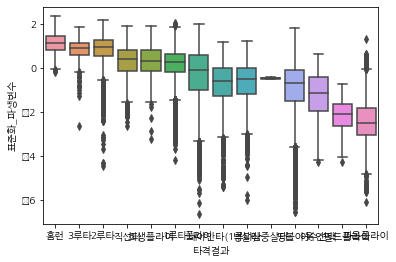

In [23]:
sns.boxplot(x = '타격결과',y = '표준화_파생변수', data=hts_pasaeng, order = ['홈런', '3루타', '2루타', '직선타', '희생플라이', 
                                                              '1루타', '플라이', '내야안타(1루타)', '병살타', '삼중살타',
                                                             '땅볼아웃', '야수선택', '인필드플라이', '파울플라이'])

In [24]:
hts_pasaeng

,경기코드,선수코드,이닝,타구속도,발사각도,타격결과,안타여부,장타여부,파생_발사각도,표준화_속도,표준화_각도,파생변수,표준화_파생변수
0,20180324HHWO0,62797,1,131.50,42.7,플라이,0,0,78.322842,-0.226599,-0.177340,209.822842,-0.403939
1,20180324HHWO0,76753,1,135.18,9.9,1루타,1,1,88.877158,-0.093603,0.342577,224.057158,0.248974
2,20180324HHWO0,71752,1,152.41,2.1,1루타,1,1,81.077158,0.529093,-0.041659,233.487158,0.487434
3,20180324HHWO0,62700,1,113.72,13.5,1루타,1,1,92.477158,-0.869172,0.519917,206.197158,-0.349255
4,20180324HHWO0,78288,2,161.90,3.5,1루타,1,1,82.477158,0.872064,0.027306,244.377158,0.899370
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120409,20210711LTSS0,50458,8,141.23,-4.9,땅볼아웃,0,0,74.077158,0.125045,-0.386487,215.307158,-0.261442
120410,20210711LTSS0,62415,8,101.09,31.8,1루타,1,1,89.222842,-1.325623,0.359606,190.312842,-0.966018
120411,20210711LTSS0,75566,8,146.84,33.4,홈런,1,4,87.622842,0.327792,0.280788,234.462842,0.608580
120412,20210711LTSS0,69418,8,146.12,23.9,홈런,1,4,97.122842,0.301771,0.748768,243.242842,1.050539


In [25]:
########### hts 파일 최종 완료

hts_pasaeng

,경기코드,선수코드,이닝,타구속도,발사각도,타격결과,안타여부,장타여부,파생_발사각도,표준화_속도,표준화_각도,파생변수,표준화_파생변수
0,20180324HHWO0,62797,1,131.50,42.7,플라이,0,0,78.322842,-0.226599,-0.177340,209.822842,-0.403939
1,20180324HHWO0,76753,1,135.18,9.9,1루타,1,1,88.877158,-0.093603,0.342577,224.057158,0.248974
2,20180324HHWO0,71752,1,152.41,2.1,1루타,1,1,81.077158,0.529093,-0.041659,233.487158,0.487434
3,20180324HHWO0,62700,1,113.72,13.5,1루타,1,1,92.477158,-0.869172,0.519917,206.197158,-0.349255
4,20180324HHWO0,78288,2,161.90,3.5,1루타,1,1,82.477158,0.872064,0.027306,244.377158,0.899370
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120409,20210711LTSS0,50458,8,141.23,-4.9,땅볼아웃,0,0,74.077158,0.125045,-0.386487,215.307158,-0.261442
120410,20210711LTSS0,62415,8,101.09,31.8,1루타,1,1,89.222842,-1.325623,0.359606,190.312842,-0.966018
120411,20210711LTSS0,75566,8,146.84,33.4,홈런,1,4,87.622842,0.327792,0.280788,234.462842,0.608580
120412,20210711LTSS0,69418,8,146.12,23.9,홈런,1,4,97.122842,0.301771,0.748768,243.242842,1.050539


In [26]:
hts_pasaeng.describe()

,선수코드,이닝,타구속도,발사각도,안타여부,장타여부,파생_발사각도,표준화_속도,표준화_각도,파생변수,표준화_파생변수
count,120414.000000,120414.000000,120414.000000,120414.000000,120414.000000,120414.000000,120414.000000,120414.000000,120414.000000,120414.000000,120414.000000
mean,69755.175636,4.934194,133.990547,17.474867,0.400261,0.552021,80.063996,-0.136590,-0.091569,214.054543,-0.228159
std,7390.640284,2.585314,20.778306,24.046791,0.489953,0.942156,13.906432,0.750933,0.685046,28.284281,1.159533
min,50054.000000,1.000000,9.880000,-68.100000,0.000000,0.000000,10.877158,-4.621973,-3.499787,51.932842,-6.634953
25%,63963.000000,3.000000,121.850000,-1.400000,0.000000,0.000000,71.277158,-0.575352,-0.524418,198.187158,-0.860833
50%,69209.000000,5.000000,137.770000,14.600000,0.000000,0.000000,81.922842,0.000000,0.000000,219.590000,-0.008854
75%,76313.000000,7.000000,149.520000,32.200000,1.000000,1.000000,91.577158,0.424648,0.475582,234.762842,0.618273
max,99810.000000,12.000000,210.130000,89.800000,1.000000,4.000000,99.977158,2.615107,0.889375,278.147158,2.349440


In [156]:
# barrel_point를 조절하면서 안타 5할, 장타율 1.5의 범위를 찾아야 함
barrel_point = 0.86888888

# 위의 barrel_point의 이상의 타구들을 barrel1으로 설정
barrel1 = hts_pasaeng[(hts_pasaeng['표준화_파생변수'] > barrel_point)]

# 그리고 위의 barrel_point의 이상을 넘는 타구는 배럴여부 col에 1로 표시
hts_pasaeng['배럴여부'] = 0
hts_pasaeng['배럴여부'][(hts_pasaeng['표준화_파생변수'] > barrel_point)] = 1

In [157]:
hts_pasaeng['배럴여부'].sum()

19153

In [158]:
barrel1.describe()

,선수코드,이닝,타구속도,발사각도,안타여부,장타여부,파생_발사각도,표준화_속도,표준화_각도,파생변수,표준화_파생변수,배럴여부
count,19153.000000,19153.000000,19153.000000,19153.000000,19153.000000,19153.000000,19153.000000,19153.000000,19153.000000,19153.000000,19153.000000,19153.00000
mean,70284.358429,4.964131,154.446177,18.642557,0.692737,1.470997,93.891234,0.602681,0.589576,248.337410,1.192257,0.97875
std,7311.898375,2.576527,7.298296,7.303444,0.461371,1.441242,4.656971,0.263762,0.229407,6.213377,0.239771,0.14422
min,50054.000000,1.000000,137.300000,-13.300000,0.000000,0.000000,65.677158,-0.016986,-0.800280,237.277158,0.868893,0.00000
25%,64300.000000,3.000000,149.070000,13.600000,0.000000,0.000000,91.177158,0.408385,0.455878,243.572842,0.996714,1.00000
50%,70410.000000,5.000000,154.270000,18.900000,1.000000,1.000000,94.877158,0.596314,0.638144,247.237158,1.145942,1.00000
75%,76313.000000,7.000000,159.490000,23.700000,1.000000,2.000000,97.577158,0.784966,0.771149,252.197158,1.342737,1.00000
max,99810.000000,12.000000,210.130000,44.400000,1.000000,4.000000,99.977158,2.615107,0.889375,278.147158,2.349440,1.00000


- 18시즌 삼진 : 	10688
- 19시즌 삼진 : 9595
- 20시즌 삼진 : 9855
- 21시즌 삼진 : 6000(추정치)
- 합계
- 10688+9595+9855+6000

## 배럴타구 범위 설정
 - 안타여부 col은 0, 1로 이루어져 있으므로 .sum()
 - 타율은 삼진을 포함하고 볼넷, 희생플라이, 희생번트를 제외하고 계산하는 것인데 번트는 이미 삭제했고, 희생플라이 제외
 - 해당 기간의 삼진 갯수 10688+9595+9855+6000에 hts DF에서 barrel1으로 설정된 비율을 곱해서 대략적인 삼진갯수를 포함
 
 
**근데 이게 오류가 있을 수도 있어서 아이디어 부탁합니다...**

In [159]:
hitter = pd.read_csv('타자 기본.csv', encoding = 'CP949')

In [160]:
# 안타
barrel1['안타여부'].sum()/(len(barrel1['안타여부'])
                       + (10688+9595+9855+6000)*len(barrel1)/len(hts) 
                       - len(barrel1.loc[(barrel1['타격결과'] == '희생플라이')]))

0.5404900049480599

In [161]:
# 장타
barrel1['장타여부'].sum()/(len(barrel1['장타여부']) 
                       - len(barrel1.loc[(barrel1['타격결과'] == '희생플라이')]))

1.4986170212765957

<AxesSubplot:xlabel='타구속도', ylabel='발사각도'>

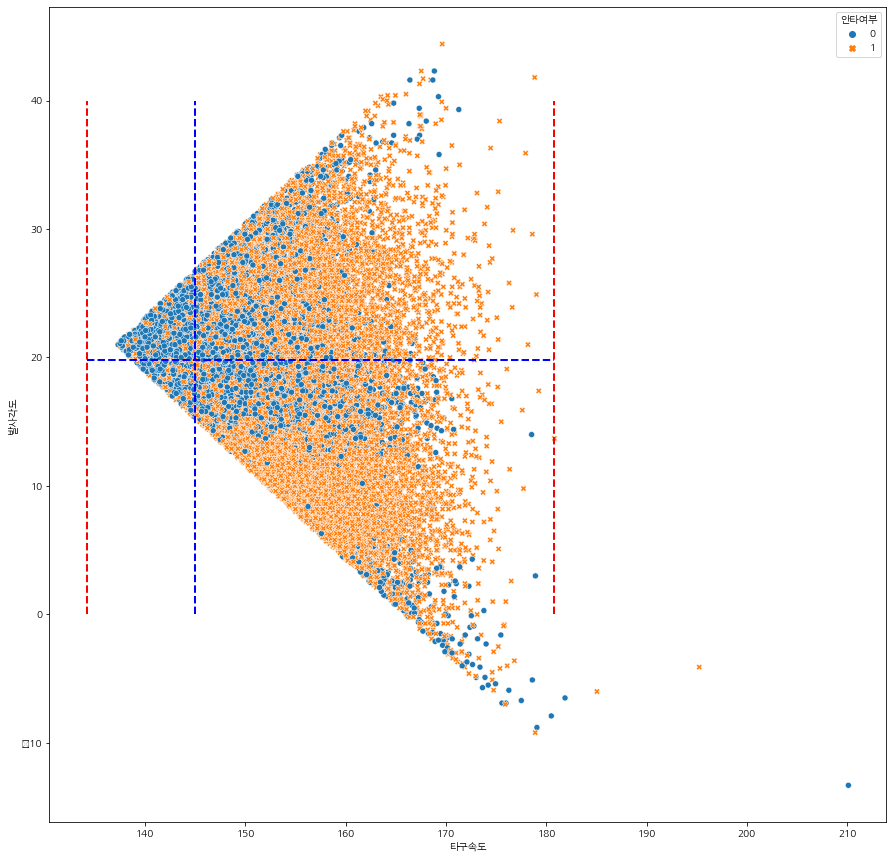

In [162]:
plt.subplots(figsize=(15, 15))
plt.plot([134.25, 134.25], [0, 40], "--r", linewidth=2) #min

plt.plot([145.0, 145.0], [0, 40], "--b", linewidth=2)

plt.plot([180.81, 180.81], [0, 40], "--r", linewidth=2) #max
plt.plot([134.25, 180.81], [19.811539461708612, 19.811539461708612], "--b", linewidth=2)
sns.scatterplot(x="타구속도", y="발사각도", hue = '안타여부', style = '안타여부', data=barrel1)

In [108]:
barrel1['타구속도'].min()

138.31

In [186]:
a = 160.5
b = 170
c = 177
d = 180.5

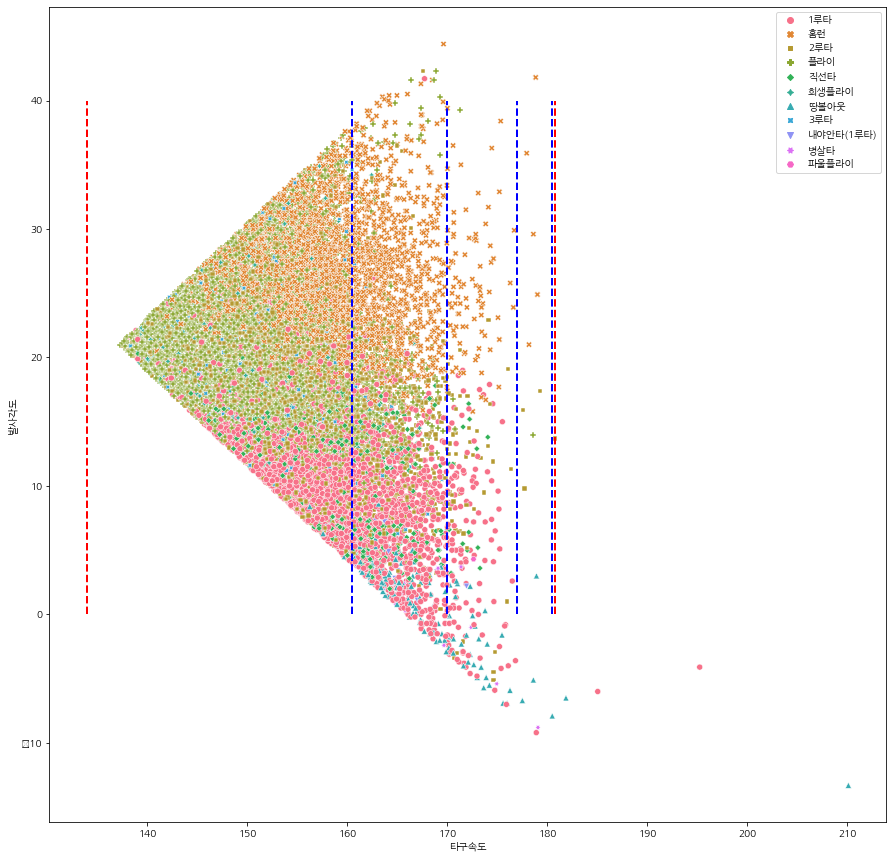

In [187]:
plt.subplots(figsize=(15, 15))
sns.scatterplot(x="타구속도", y="발사각도", hue = '타격결과', style = '타격결과', data=barrel1)
plt.plot([134.0, 134.0], [0, 40], "--r", linewidth=2) #min

plt.plot([a, a], [0, 40], "--b", linewidth=2) # 9.312
plt.plot([b, b], [0, 40], "--b", linewidth=2)
plt.plot([c, c], [0, 40], "--b", linewidth=2)
plt.plot([d, d], [0, 40], "--b", linewidth=2)

plt.plot([180.81, 180.81], [0, 40], "--r", linewidth=2) #max
# plt.plot([134.25, 180.81], [19.811539461708612, 19.811539461708612], "--b", linewidth=2)

plt.legend()
plt.show()

In [188]:
barrel_1 = barrel1[(barrel1['타구속도']>=134.25) &(barrel1['타구속도']<a)]
barrel_2 = barrel1[(barrel1['타구속도']>=a) &(barrel1['타구속도']<b)]
barrel_3 = barrel1[(barrel1['타구속도']>=b) &(barrel1['타구속도']<c)]
barrel_4 = barrel1[(barrel1['타구속도']>=c) &(barrel1['타구속도']<d)]
barrel_5 = barrel1[(barrel1['타구속도']>=d) &(barrel1['타구속도']<180.81)]

In [189]:
print('-----------안타여부-----------')
print('1 : ', barrel_1['안타여부'].sum() / (len(barrel_1['안타여부']) 
                                        + (10688+9595+9855+6000)*len(barrel_1)/len(hts)
                                       - len(barrel_1.loc[(barrel_1['타격결과'] == '희생플라이')])))

print('2 : ', barrel_2['안타여부'].sum() / (len(barrel_2['안타여부']) 
                                        + (10688+9595+9855+6000)*len(barrel_2)/len(hts)
                                       - len(barrel_2.loc[(barrel_2['타격결과'] == '희생플라이')])))

print('3 : ', barrel_3['안타여부'].sum() / (len(barrel_3['안타여부']) 
                                        + (10688+9595+9855+6000)*len(barrel_3)/len(hts)
                                       - len(barrel_3.loc[(barrel_3['타격결과'] == '희생플라이')])))

print('4 : ', barrel_4['안타여부'].sum() / (len(barrel_4['안타여부']) 
                                        + (10688+9595+9855+6000)*len(barrel_4)/len(hts)
                                       - len(barrel_4.loc[(barrel_4['타격결과'] == '희생플라이')])))

print('5 : ', barrel_5['안타여부'].sum() / (len(barrel_5['안타여부']) 
                                        + (10688+9595+9855+6000)*len(barrel_5)/len(hts)
                                       - len(barrel_5.loc[(barrel_5['타격결과'] == '희생플라이')])))
# print('2 : ', barrel_2['안타여부'].mean())
# print('3 : ', barrel_3['안타여부'].mean())
# print('4 : ', barrel_4['안타여부'].mean())
# print('5 : ', barrel_5['안타여부'].mean())

# barrel1['안타여부'].sum()/(len(barrel1['안타여부'])
#                        + (10688+9595+9855+6000)*len(barrel1)/len(hts) 
#                        - len(barrel1.loc[(barrel1['타격결과'] == '희생플라이')]))

print('-----------장타여부-----------')


print('1 : ', barrel_1['장타여부'].sum()/(len(barrel_1['장타여부']) 
                       - len(barrel_1.loc[(barrel1['타격결과'] == '희생플라이')])))

print('2 : ', barrel_2['장타여부'].sum()/(len(barrel_2['장타여부']) 
                       - len(barrel_2.loc[(barrel1['타격결과'] == '희생플라이')])))

print('3 : ', barrel_3['장타여부'].sum()/(len(barrel_3['장타여부']) 
                       - len(barrel_3.loc[(barrel1['타격결과'] == '희생플라이')])))

print('4 : ', barrel_4['장타여부'].sum()/(len(barrel_4['장타여부']) 
                       - len(barrel_4.loc[(barrel1['타격결과'] == '희생플라이')])))

print('5 : ', barrel_5['장타여부'].sum()/(len(barrel_5['장타여부']) 
                       - len(barrel_5.loc[(barrel1['타격결과'] == '희생플라이')])))
# print('2 : ', barrel_2['장타여부'].mean())
# print('3 : ', barrel_3['장타여부'].mean())
# print('4 : ', barrel_4['장타여부'].mean())
# print('5 : ', barrel_5['장타여부'].mean())

print('-------------갯수-------------')
print('1 : ', len(barrel_1))
print('2 : ', len(barrel_2))
print('3 : ', len(barrel_3))
print('4 : ', len(barrel_4))
print('5 : ', len(barrel_5))
print('total :', len(barrel_1) + len(barrel_2) + len(barrel_3) + len(barrel_4) + len(barrel_5))

-----------안타여부-----------
1 :  0.5021624423307924
2 :  0.6836751226324219
3 :  0.6792300616752557
4 :  0.49446190403188717
5 :  0.0
-----------장타여부-----------
1 :  1.394318566114305
2 :  1.891825613079019
3 :  1.8
4 :  1.9285714285714286
5 :  0.0
-------------갯수-------------
1 :  15119
2 :  3689
3 :  325
4 :  14
5 :  1
total : 19148


In [113]:
len(barrel1)

17946

In [114]:
barrel1 = barrel1.reset_index(drop = True)

- barrel1에 있는 타격결과들을 살펴본 결과 파울플라이가 있어서 봄

In [115]:
barrel1['타격결과'].value_counts()

플라이          4957
2루타          4454
1루타          3549
홈런           3351
직선타           783
3루타           360
희생플라이         331
땅볼아웃          139
내야안타(1루타)      12
병살타             9
파울플라이           1
Name: 타격결과, dtype: int64

In [116]:
barrel1.loc[(barrel1['타격결과'] == '파울플라이')]

,경기코드,선수코드,이닝,타구속도,발사각도,타격결과,안타여부,장타여부,파생_발사각도,표준화_속도,표준화_각도,파생변수,표준화_파생변수,배럴여부
9953,20190908OBLG0,69165,1,172.62,4.3,파울플라이,0,0,83.277158,1.259487,0.066715,255.897158,1.326202,1


In [117]:
player = pd.read_csv('선수.csv', encoding = 'CP949')

In [118]:
player.loc[(player['선수코드'] == 69165)]

,연도,선수코드,선수명,팀코드,포지션,나이,연봉
1072,2019,69165,페게로,LG,내,32,150000달러


https://sports.news.naver.com/kbaseball/vod/index?id=581483&category=kbo&gameId=20190908OBLG02019&date=20190908&listType=game

- 여기 19분 43초부터 보면 매우 잘 맞은 직선타인데 파울 공간에서 잡아서 파울플라이로 표시함;;
 - 잘못 필터링 된 것이 아님을 확인

In [119]:
barrel1.describe()

,선수코드,이닝,타구속도,발사각도,안타여부,장타여부,파생_발사각도,표준화_속도,표준화_각도,파생변수,표준화_파생변수,배럴여부
count,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000
mean,70301.222891,4.974312,154.754521,18.745319,0.697036,1.501226,94.085664,0.613824,0.599154,248.840185,1.212978,0.794606
std,7301.655308,2.577602,7.152101,7.076992,0.459553,1.450905,4.504431,0.258479,0.221893,6.073909,0.233534,0.404000
min,50054.000000,1.000000,138.310000,-13.300000,0.000000,0.000000,65.677158,0.019516,-0.800280,238.142842,0.900046,0.000000
25%,64300.000000,3.000000,149.530000,13.900000,0.000000,0.000000,91.422842,0.425009,0.467980,244.182842,1.022831,1.000000
50%,70410.000000,5.000000,154.540000,19.000000,1.000000,1.000000,95.022842,0.606072,0.645320,247.770000,1.166083,1.000000
75%,76313.000000,7.000000,159.690000,23.700000,1.000000,2.000000,97.677158,0.792194,0.776075,252.597158,1.359042,1.000000
max,99810.000000,12.000000,210.130000,42.300000,1.000000,4.000000,99.977158,2.615107,0.889375,278.147158,2.349440,1.000000


In [120]:
hts_pasaeng

,경기코드,선수코드,이닝,타구속도,발사각도,타격결과,안타여부,장타여부,파생_발사각도,표준화_속도,표준화_각도,파생변수,표준화_파생변수,배럴여부
0,20180324HHWO0,62797,1,131.50,42.7,플라이,0,0,78.322842,-0.226599,-0.177340,209.822842,-0.403939,0
1,20180324HHWO0,76753,1,135.18,9.9,1루타,1,1,88.877158,-0.093603,0.342577,224.057158,0.248974,0
2,20180324HHWO0,71752,1,152.41,2.1,1루타,1,1,81.077158,0.529093,-0.041659,233.487158,0.487434,0
3,20180324HHWO0,62700,1,113.72,13.5,1루타,1,1,92.477158,-0.869172,0.519917,206.197158,-0.349255,0
4,20180324HHWO0,78288,2,161.90,3.5,1루타,1,1,82.477158,0.872064,0.027306,244.377158,0.899370,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120409,20210711LTSS0,50458,8,141.23,-4.9,땅볼아웃,0,0,74.077158,0.125045,-0.386487,215.307158,-0.261442,0
120410,20210711LTSS0,62415,8,101.09,31.8,1루타,1,1,89.222842,-1.325623,0.359606,190.312842,-0.966018,0
120411,20210711LTSS0,75566,8,146.84,33.4,홈런,1,4,87.622842,0.327792,0.280788,234.462842,0.608580,0
120412,20210711LTSS0,69418,8,146.12,23.9,홈런,1,4,97.122842,0.301771,0.748768,243.242842,1.050539,1


In [121]:
barrel1

,경기코드,선수코드,이닝,타구속도,발사각도,타격결과,안타여부,장타여부,파생_발사각도,표준화_속도,표준화_각도,파생변수,표준화_파생변수,배럴여부
0,20180324HHWO0,71752,3,155.49,21.0,1루타,1,1,99.977158,0.640405,0.889375,255.467158,1.529780,1
1,20180324HHWO0,76746,3,165.04,20.3,홈런,1,4,99.277158,0.985544,0.854892,264.317158,1.840436,1
2,20180324HHWO0,67341,4,151.98,18.4,2루타,1,2,97.377158,0.513553,0.761296,249.357158,1.274849,1
3,20180324HHWO0,67341,5,141.49,23.0,플라이,0,0,98.022842,0.134442,0.793103,239.512842,0.927545,0
4,20180324HHWO0,61353,6,141.75,20.1,플라이,0,0,99.077158,0.143838,0.845040,240.827158,0.988878,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17941,20210711KTHT0,78603,6,142.02,22.4,2루타,1,2,98.622842,0.153596,0.822660,240.642842,0.976256,0
17942,20210711KTHT0,72443,6,153.73,31.1,홈런,1,4,89.922842,0.576798,0.394089,243.652842,0.970887,0
17943,20210711LTSS0,66838,2,149.83,18.6,희생플라이,0,0,97.577158,0.435851,0.771149,247.407158,1.207000,1
17944,20210711LTSS0,71564,4,152.75,15.2,1루타,1,1,94.177158,0.541381,0.603661,246.927158,1.145041,1


In [122]:
hts_pasaeng

,경기코드,선수코드,이닝,타구속도,발사각도,타격결과,안타여부,장타여부,파생_발사각도,표준화_속도,표준화_각도,파생변수,표준화_파생변수,배럴여부
0,20180324HHWO0,62797,1,131.50,42.7,플라이,0,0,78.322842,-0.226599,-0.177340,209.822842,-0.403939,0
1,20180324HHWO0,76753,1,135.18,9.9,1루타,1,1,88.877158,-0.093603,0.342577,224.057158,0.248974,0
2,20180324HHWO0,71752,1,152.41,2.1,1루타,1,1,81.077158,0.529093,-0.041659,233.487158,0.487434,0
3,20180324HHWO0,62700,1,113.72,13.5,1루타,1,1,92.477158,-0.869172,0.519917,206.197158,-0.349255,0
4,20180324HHWO0,78288,2,161.90,3.5,1루타,1,1,82.477158,0.872064,0.027306,244.377158,0.899370,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120409,20210711LTSS0,50458,8,141.23,-4.9,땅볼아웃,0,0,74.077158,0.125045,-0.386487,215.307158,-0.261442,0
120410,20210711LTSS0,62415,8,101.09,31.8,1루타,1,1,89.222842,-1.325623,0.359606,190.312842,-0.966018,0
120411,20210711LTSS0,75566,8,146.84,33.4,홈런,1,4,87.622842,0.327792,0.280788,234.462842,0.608580,0
120412,20210711LTSS0,69418,8,146.12,23.9,홈런,1,4,97.122842,0.301771,0.748768,243.242842,1.050539,1


In [123]:
Rojas = hts_pasaeng[hts_pasaeng['선수코드'] == 67025]
Rojas

,경기코드,선수코드,이닝,타구속도,발사각도,타격결과,안타여부,장타여부,파생_발사각도,표준화_속도,표준화_각도,파생변수,표준화_파생변수,배럴여부
72,20180324KTHT0,67025,6,147.62,27.7,홈런,1,4,93.322842,0.355981,0.561576,240.942842,0.917558,1
81,20180324KTHT0,67025,7,165.54,24.1,홈런,1,4,96.922842,1.003614,0.738916,262.462842,1.742530,1
267,20180325KTHT0,67025,1,103.12,50.4,플라이,0,0,70.622842,-1.252259,-0.556650,173.742842,-1.808909,0
288,20180325KTHT0,67025,4,128.61,23.2,플라이,0,0,97.822842,-0.331044,0.783251,226.432842,0.452207,0
304,20180325KTHT0,67025,7,150.35,0.6,1루타,1,1,79.577158,0.454644,-0.115551,229.927158,0.339093,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102018,20201029KTHH0,67025,1,120.89,17.4,1루타,1,1,96.377158,-0.610047,0.712035,217.267158,0.101988,0
102048,20201029KTHH0,67025,6,153.36,13.8,1루타,1,1,92.777158,0.563426,0.534695,246.137158,1.098121,1
102233,20201030KTHH0,67025,1,145.88,-1.6,1루타,1,1,77.377158,0.293097,-0.223925,223.257158,0.069172,0
102239,20201030KTHH0,67025,2,140.64,49.3,플라이,0,0,71.722842,0.103722,-0.502463,212.362842,-0.398741,0


In [124]:
Rojas['배럴여부'].sum()/1851

0.16315505132360886

In [125]:
hitter = pd.read_csv('타자 기본.csv', encoding = 'CP949')

In [126]:
def barrel_ws(df_hts, df_player,df_hitter,name,point):
    code = df_player[df_player['선수명'] == name]['선수코드'].unique()[0] #이름 입력 받아서 선수코드 int로 가져옴
    
    df_name = hts_pasaeng[hts_pasaeng['선수코드'] == code]
#     df_name = hts_pasaeng[(hts_pasaeng['표준화_파생변수'] > point)]
#     df_name = df_name[(df_name['발사각도'] > 15) & (df_name['발사각도'] < 35)]
    
    #타율(BA) 계산하기 위해 필요
    ba = df_name[df_name['타격결과'] == '1루타'].shape[0] + df_name[df_name['타격결과'] == '2루타'].shape[0] + df_name[df_name['타격결과'] == '3루타'].shape[0] +df_name[df_name['타격결과'] == '홈런'].shape[0]
    #장타율(SLG) 계산하기 위해 필요
    slg = df_name[df_name['타격결과'] == '1루타'].shape[0] + df_name[df_name['타격결과'] == '2루타'].shape[0] *2 + df_name[df_name['타격결과'] == '3루타'].shape[0] * 3 + df_name[df_name['타격결과'] == '홈런'].shape[0]*4
    
    print('----------', name,'----------')
#     print('타율 = ',ba , '/',df_name.shape[0], ' = ', ba / df_name.shape[0])
#     print('장타율 = ',slg , '/',df_name.shape[0], ' = ', slg / df_name.shape[0])
    print('배럴타구 = ',df_name['배럴여부'].sum() )
    print('배럴타구 / 타석 = ',df_name['배럴여부'].sum(), '/', df_hitter[df_hitter['선수코드'] == code]['타석'].sum(), 
                                                  '=',df_name['배럴여부'].sum() / df_hitter[df_hitter['선수코드'] == code]['타석'].sum())
    print()
    

- 효림이 함수를 수정해서 top20 선수들 barrel을 본 결과 대부분 10% 초반을 기록했으며, 효림이의 결과와 비슷한 양상을 보임

In [127]:
name_list = ['양의지', '강백호', '최정', '이정후', '홍창기', '피렐라', '강민호', '박동원', '나성범', '박건우',
            '김재환', '페르난데스', '김현수', '양석환', '알테어', '정훈', '추신수', '구자욱', '안치홍', '한유섬']

for name in name_list:
    barrel_ws(hts, player, hitter, name, barrel_point)

---------- 양의지 ----------
배럴타구 =  305
배럴타구 / 타석 =  305 / 1792 = 0.17020089285714285

---------- 강백호 ----------
배럴타구 =  297
배럴타구 / 타석 =  297 / 1993 = 0.14902157551430004

---------- 최정 ----------
배럴타구 =  248
배럴타구 / 타석 =  248 / 1953 = 0.12698412698412698

---------- 이정후 ----------
배럴타구 =  210
배럴타구 / 타석 =  210 / 2123 = 0.09891662741403674

---------- 홍창기 ----------
배럴타구 =  105
배럴타구 / 타석 =  105 / 899 = 0.1167964404894327

---------- 피렐라 ----------
배럴타구 =  50
배럴타구 / 타석 =  50 / 361 = 0.13850415512465375

---------- 강민호 ----------
배럴타구 =  163
배럴타구 / 타석 =  163 / 1533 = 0.10632746249184605

---------- 박동원 ----------
배럴타구 =  140
배럴타구 / 타석 =  140 / 1122 = 0.12477718360071301

---------- 나성범 ----------
배럴타구 =  245
배럴타구 / 타석 =  245 / 1648 = 0.1486650485436893

---------- 박건우 ----------
배럴타구 =  294
배럴타구 / 타석 =  294 / 1863 = 0.15780998389694043

---------- 김재환 ----------
배럴타구 =  351
배럴타구 / 타석 =  351 / 2079 = 0.16883116883116883

---------- 페르난데스 ----------
배럴타구 =  179
배럴타구 / 타석 =  179 / 1632 = 0.1096

In [128]:
hts.to_csv('hts_기본파일_robust.csv', encoding = 'cp949', index = False)

In [61]:
#--------------------------------------------------modeling-----

In [223]:
df = pd.read_csv('hts_기본파일.csv', encoding = 'cp949')

In [224]:
df.drop('경기코드', inplace = True, axis = 1)

In [225]:
df=pd.get_dummies(df)
df.head()

,선수코드,이닝,타구속도,발사각도,안타여부,장타여부,파생_발사각도,표준화_속도,표준화_각도,파생변수,...,타격결과_땅볼아웃,타격결과_병살타,타격결과_삼중살타,타격결과_야수선택,타격결과_인필드플라이,타격결과_직선타,타격결과_파울플라이,타격결과_플라이,타격결과_홈런,타격결과_희생플라이
0,62797,1,131.50,42.7,0,0,78.322842,0.607341,0.756966,10299.453773,...,0,0,0,0,0,0,0,1,0,0
1,76753,1,135.18,9.9,1,1,88.877158,0.625718,0.875421,12014.414167,...,0,0,0,0,0,0,0,0,0,0
2,71752,1,152.41,2.1,1,1,81.077158,0.711760,0.787879,12356.969593,...,0,0,0,0,0,0,0,0,0,0
3,62700,1,113.72,13.5,1,1,92.477158,0.518552,0.915825,10516.502365,...,0,0,0,0,0,0,0,0,0,0
4,78288,2,161.90,3.5,1,1,82.477158,0.759151,0.803591,13353.051819,...,0,0,0,0,0,0,0,0,0,0


In [226]:
df

,선수코드,이닝,타구속도,발사각도,안타여부,장타여부,파생_발사각도,표준화_속도,표준화_각도,파생변수,...,타격결과_땅볼아웃,타격결과_병살타,타격결과_삼중살타,타격결과_야수선택,타격결과_인필드플라이,타격결과_직선타,타격결과_파울플라이,타격결과_플라이,타격결과_홈런,타격결과_희생플라이
0,62797,1,131.50,42.7,0,0,78.322842,0.607341,0.756966,10299.453773,...,0,0,0,0,0,0,0,1,0,0
1,76753,1,135.18,9.9,1,1,88.877158,0.625718,0.875421,12014.414167,...,0,0,0,0,0,0,0,0,0,0
2,71752,1,152.41,2.1,1,1,81.077158,0.711760,0.787879,12356.969593,...,0,0,0,0,0,0,0,0,0,0
3,62700,1,113.72,13.5,1,1,92.477158,0.518552,0.915825,10516.502365,...,0,0,0,0,0,0,0,0,0,0
4,78288,2,161.90,3.5,1,1,82.477158,0.759151,0.803591,13353.051819,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120409,50458,8,141.23,-4.9,0,0,74.077158,0.655930,0.709315,10461.916971,...,1,0,0,0,0,0,0,0,0,0
120410,62415,8,101.09,31.8,1,1,89.222842,0.455481,0.879301,9019.537136,...,0,0,0,0,0,0,0,0,0,0
120411,75566,8,146.84,33.4,1,4,87.622842,0.683945,0.861343,12866.538175,...,0,0,0,0,0,0,0,0,1,0
120412,69418,8,146.12,23.9,1,4,97.122842,0.680350,0.967965,14191.589728,...,0,0,0,0,0,0,0,0,1,0


In [227]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120414 entries, 0 to 120413
Data columns (total 26 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   선수코드            120414 non-null  int64  
 1   이닝              120414 non-null  int64  
 2   타구속도            120414 non-null  float64
 3   발사각도            120414 non-null  float64
 4   안타여부            120414 non-null  int64  
 5   장타여부            120414 non-null  int64  
 6   파생_발사각도         120414 non-null  float64
 7   표준화_속도          120414 non-null  float64
 8   표준화_각도          120414 non-null  float64
 9   파생변수            120414 non-null  float64
 10  표준화_파생변수        120414 non-null  float64
 11  배럴여부            120414 non-null  int64  
 12  타격결과_1루타        120414 non-null  uint8  
 13  타격결과_2루타        120414 non-null  uint8  
 14  타격결과_3루타        120414 non-null  uint8  
 15  타격결과_내야안타(1루타)  120414 non-null  uint8  
 16  타격결과_땅볼아웃       120414 non-null  uint8  
 17  타격결과_병살타  

In [228]:
df_raw_y = df[['안타여부']]# 목표변수
df_raw_x = df[['타구속도', '발사각도','타격결과_1루타', '타격결과_2루타', '타격결과_3루타', '타격결과_홈런']] # 독립변수

In [229]:
# train, test set 나누기
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, test_size = 0.3, random_state = 1234)

print('train data x size : {}'.format(df_train_x.shape))
print('train data y size : {}'.format(df_train_y.shape))
print('test data x size : {}'.format(df_test_x.shape))
print('test data y size : {}'.format(df_test_y.shape))

train data x size : (84289, 6)
train data y size : (84289, 1)
test data x size : (36125, 6)
test data y size : (36125, 1)


In [230]:
# 기본 성능 모델
gb_uncustomized = xgb.XGBRegressor(random_state = 1234)
gb_uncustomized.fit(df_train_x, df_train_y)

print('Score on trainning set : {:3f}'.format(gb_uncustomized.score(df_train_x, df_train_y)))
print('Score on test set : {:3f}'.format(gb_uncustomized.score(df_test_x, df_test_y)))

Score on trainning set : 0.909584
Score on test set : 0.890605


,Estimators,TrainScore,TestScore
0,10,0.477,0.464
1,20,0.485,0.467
2,30,0.490,0.467
3,40,0.494,0.466
4,50,0.500,0.466
5,60,0.504,0.465
6,70,0.508,0.464
7,80,0.511,0.463
8,90,0.513,0.463
9,100,0.517,0.462


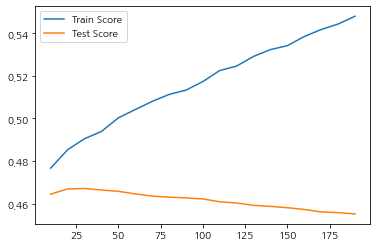

In [87]:
# 트리 수 변경에 따른 모델 성능

train_score = []
test_score = []

para_n_tree = [n_tree * 10 for n_tree in range(1, 20)]

for v_n_estimators in para_n_tree:
    gb = xgb.XGBRegressor(random_state = 1234, n_estimators = v_n_estimators)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
df_score_n = pd.DataFrame()
df_score_n['Estimators'] = para_n_tree
df_score_n['TrainScore'] = train_score
df_score_n['TestScore'] = test_score

# 트리 수 그래프 확인
plt.plot(para_n_tree, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_n_tree, test_score, linestyle = '-', label = 'Test Score')
plt.legend()

df_score_n.round(3)

,SubSample,TrainScore,TestScore
0,0.1,0.466,0.446
1,0.2,0.480,0.457
2,0.3,0.483,0.460
3,0.4,0.488,0.462
4,0.5,0.488,0.465
5,0.6,0.490,0.466
6,0.7,0.492,0.465
7,0.8,0.492,0.468
8,0.9,0.489,0.467
9,1.0,0.490,0.467


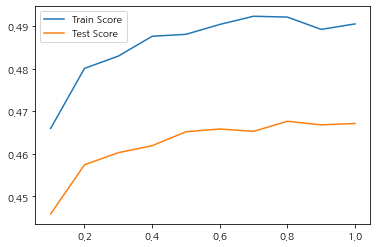

In [88]:


train_score = []
test_score = []

para_subsample = [sample * 0.1 for sample in range(1, 11)]

for v_subsample in para_subsample:
    rf = xgb.XGBRegressor(random_state = 1234, n_estimators = 30,
                                  subsample = v_subsample)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
    
df_score_sample = pd.DataFrame()
df_score_sample['SubSample'] = para_subsample
df_score_sample['TrainScore'] = train_score
df_score_sample['TestScore'] = test_score

plt.plot(para_subsample, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_subsample, test_score, linestyle = '-', label = 'Test Score')
plt.legend()

df_score_sample.round(3)

,Colsample,TrainScore,TestScore
0,0.1,0.384,0.374
1,0.2,0.384,0.374
2,0.3,0.384,0.374
3,0.4,0.384,0.374
4,0.5,0.384,0.374
5,0.6,0.384,0.374
6,0.7,0.384,0.374
7,0.8,0.384,0.374
8,0.9,0.384,0.374
9,1.0,0.492,0.468


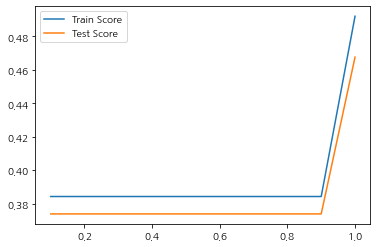

In [89]:
train_score = []
test_score = []

para_colsample_bytree = [n_colsample_bytree*0.1 for n_colsample_bytree in range(1, 11)]

for v_colsample_bytree in para_colsample_bytree:
    gb = xgb.XGBRegressor(random_state = 1234, n_estimators = 30, subsample = 0.8,
                                  colsample_bytree = v_colsample_bytree)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
df_score_colsample_bytree = pd.DataFrame()
df_score_colsample_bytree['Colsample'] = para_colsample_bytree
df_score_colsample_bytree['TrainScore'] = train_score
df_score_colsample_bytree['TestScore'] = test_score

plt.plot(para_colsample_bytree, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_colsample_bytree, test_score, linestyle = '-', label = 'Test Score')
plt.legend()

df_score_colsample_bytree.round(3)

,Depth,TrainScore,TestScore
0,1,0.353,0.350
1,2,0.411,0.408
2,3,0.448,0.445
3,4,0.471,0.464
4,5,0.482,0.468
5,6,0.492,0.468
6,7,0.503,0.465
7,8,0.523,0.460
8,9,0.546,0.455
9,10,0.572,0.446


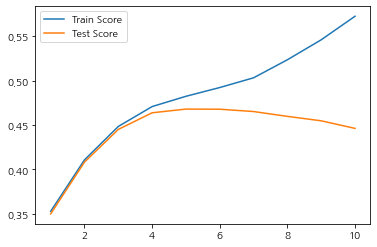

In [90]:
# 최대 깊이 변경에 따른 모델 성능

train_score = []
test_score = []

para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    gb = xgb.XGBRegressor(random_state = 1234, n_estimators = 30, subsample = 0.8,
                                  colsample_bytree = 1, max_depth = v_max_depth)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
df_score_depth = pd.DataFrame()
df_score_depth['Depth'] = para_depth
df_score_depth['TrainScore'] = train_score
df_score_depth['TestScore'] = test_score

plt.plot(para_depth, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_depth, test_score, linestyle = '-', label = 'Test Score')
plt.legend()

df_score_depth.round(3)

,LearningRate,TrainScore,TestScore
0,0.1,0.470,0.463
1,0.2,0.478,0.468
2,0.3,0.482,0.468
3,0.4,0.484,0.467
4,0.5,0.486,0.464
5,0.6,0.487,0.461
6,0.7,0.487,0.458
7,0.8,0.489,0.454
8,0.9,0.489,0.450


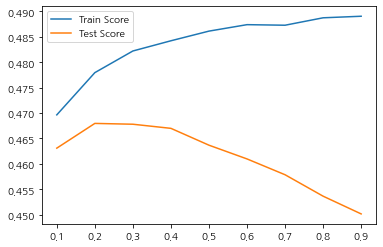

In [91]:
# learning_rate 변경에 따른 모델 성능

train_score = []
test_score = []

para_lr = [lr*0.1 for lr in range(1, 10)]

for v_learning_rate in para_lr:
    gb = xgb.XGBRegressor(random_state = 1234, n_estimators = 30, subsample = 0.8,
                                  colsample_bytree = 1, max_depth = 5, learning_rate = v_learning_rate)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
df_score_lr = pd.DataFrame()
df_score_lr['LearningRate'] = para_lr
df_score_lr['TrainScore'] = train_score
df_score_lr['TestScore'] = test_score

plt.plot(para_lr, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_lr, test_score, linestyle = '-', label = 'Test Score')
plt.legend()

df_score_lr.round(3)

In [231]:
# 최종 모델
# gblinear : 선형모형
# gbtree : 의사결정기반모형
# dart : 드롭아웃 regression trees

xgb_final = xgb.XGBRegressor(random_state = 1234, n_estimators = 30, subsample = 0.8,
                                  colsample_bytree = 1, max_depth = 5, learning_rate = 0.2)

xgb_final.fit(df_train_x, df_train_y)

print('Score on training set: {:.3f}'.format(xgb_final.score(df_train_x, df_train_y)))
print('Score on test set: {:.3f}'.format(xgb_final.score(df_test_x, df_test_y)))

Score on training set: 0.894
Score on test set: 0.889


In [73]:
# df_t = pd.read_csv('hts_기본파일.csv', encoding = 'cp949')
# df_t = df_t[['표준화_속도', '표준화_각도']]

In [232]:
# df_t = df.drop()

#  = df[['배럴여부']]# 목표변수
df_t = df[['타구속도', '발사각도','타격결과_1루타', '타격결과_2루타', '타격결과_3루타', '타격결과_홈런']] # 독립변수

In [233]:
pred = xgb_final.predict(df_t)

In [234]:
len(pred)

120414

In [235]:
#------------------------------------

In [236]:
pred

array([0.00122837, 1.0053135 , 0.99783325, ..., 0.99323565, 0.9920671 ,
       0.00479505], dtype=float32)

In [237]:
hts['안타율'] = 0
hts['안타율'] = pred

In [238]:
hts

,경기코드,선수코드,이닝,타구속도,발사각도,타격결과,안타여부,장타여부,파생_발사각도,표준화_속도,표준화_각도,파생변수,표준화_파생변수,배럴여부,안타율
0,20180324HHWO0,62797,1,131.50,42.7,플라이,0,0,78.322842,-0.226599,-0.177340,209.822842,-0.403939,0,0.001228
1,20180324HHWO0,76753,1,135.18,9.9,1루타,1,1,88.877158,-0.093603,0.342577,224.057158,0.248974,0,1.005314
2,20180324HHWO0,71752,1,152.41,2.1,1루타,1,1,81.077158,0.529093,-0.041659,233.487158,0.487434,0,0.997833
3,20180324HHWO0,62700,1,113.72,13.5,1루타,1,1,92.477158,-0.869172,0.519917,206.197158,-0.349255,0,1.005720
4,20180324HHWO0,78288,2,161.90,3.5,1루타,1,1,82.477158,0.872064,0.027306,244.377158,0.899370,1,0.997833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120409,20210711LTSS0,50458,8,141.23,-4.9,땅볼아웃,0,0,74.077158,0.125045,-0.386487,215.307158,-0.261442,0,0.052183
120410,20210711LTSS0,62415,8,101.09,31.8,1루타,1,1,89.222842,-1.325623,0.359606,190.312842,-0.966018,0,0.996174
120411,20210711LTSS0,75566,8,146.84,33.4,홈런,1,4,87.622842,0.327792,0.280788,234.462842,0.608580,0,0.993236
120412,20210711LTSS0,69418,8,146.12,23.9,홈런,1,4,97.122842,0.301771,0.748768,243.242842,1.050539,1,0.992067


In [251]:
df_raw_y2 = df[['장타여부']]# 목표변수
df_raw_x2 = df[['타구속도', '발사각도']] # 독립변수

In [252]:
# train, test set 나누기
df_train_x2, df_test_x2, df_train_y2, df_test_y2 = train_test_split(df_raw_x2, df_raw_y2, test_size = 0.3, random_state = 1234)

print('train data x size : {}'.format(df_train_x2.shape))
print('train data y size : {}'.format(df_train_y2.shape))
print('test data x size : {}'.format(df_test_x2.shape))
print('test data y size : {}'.format(df_test_y2.shape))

train data x size : (84289, 2)
train data y size : (84289, 1)
test data x size : (36125, 2)
test data y size : (36125, 1)


In [253]:
# 최종 모델
# gblinear : 선형모형
# gbtree : 의사결정기반모형
# dart : 드롭아웃 regression trees

xgb_final = xgb.XGBRegressor(random_state = 1234)

xgb_final.fit(df_train_x2, df_train_y2)

print('Score on training set: {:.3f}'.format(xgb_final.score(df_train_x2, df_train_y2)))
print('Score on test set: {:.3f}'.format(xgb_final.score(df_test_x2, df_test_y2)))

Score on training set: 0.533
Score on test set: 0.448


In [254]:
df_tt = df[['타구속도', '발사각도']] # 독립변수

In [255]:
pred = xgb_final.predict(df_tt)

In [256]:
hts['장타율'] = 0
hts['장타율'] = pred

In [257]:
hts

,경기코드,선수코드,이닝,타구속도,발사각도,타격결과,안타여부,장타여부,파생_발사각도,표준화_속도,표준화_각도,파생변수,표준화_파생변수,배럴여부,안타율,장타율
0,20180324HHWO0,62797,1,131.50,42.7,플라이,0,0,78.322842,-0.226599,-0.177340,209.822842,-0.403939,0,0.001228,0.017894
1,20180324HHWO0,76753,1,135.18,9.9,1루타,1,1,88.877158,-0.093603,0.342577,224.057158,0.248974,0,1.005314,0.989841
2,20180324HHWO0,71752,1,152.41,2.1,1루타,1,1,81.077158,0.529093,-0.041659,233.487158,0.487434,0,0.997833,0.680301
3,20180324HHWO0,62700,1,113.72,13.5,1루타,1,1,92.477158,-0.869172,0.519917,206.197158,-0.349255,0,1.005720,0.841167
4,20180324HHWO0,78288,2,161.90,3.5,1루타,1,1,82.477158,0.872064,0.027306,244.377158,0.899370,1,0.997833,0.771333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120409,20210711LTSS0,50458,8,141.23,-4.9,땅볼아웃,0,0,74.077158,0.125045,-0.386487,215.307158,-0.261442,0,0.052183,0.335021
120410,20210711LTSS0,62415,8,101.09,31.8,1루타,1,1,89.222842,-1.325623,0.359606,190.312842,-0.966018,0,0.996174,0.786638
120411,20210711LTSS0,75566,8,146.84,33.4,홈런,1,4,87.622842,0.327792,0.280788,234.462842,0.608580,0,0.993236,1.446756
120412,20210711LTSS0,69418,8,146.12,23.9,홈런,1,4,97.122842,0.301771,0.748768,243.242842,1.050539,1,0.992067,1.435966


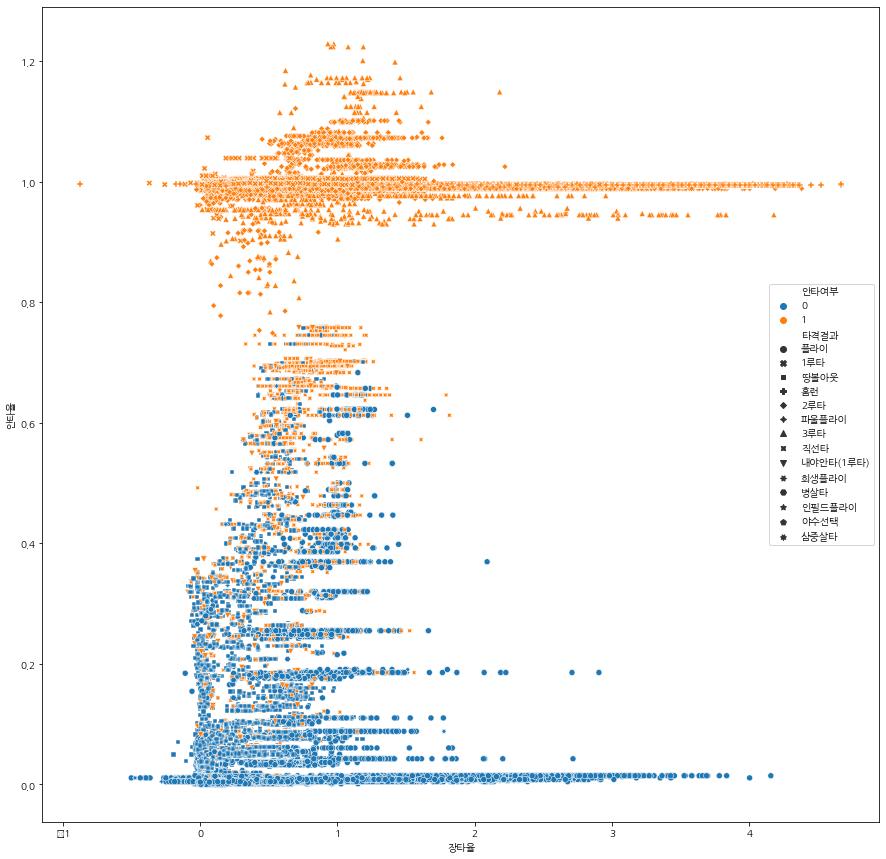

In [258]:
plt.subplots(figsize=(15, 15))
sns.scatterplot(x="장타율", y="안타율", hue = '안타여부', style = '타격결과', data=hts)
# plt.plot([134.0, 134.0], [0, 40], "--r", linewidth=2) #min

# plt.plot([a, a], [0, 40], "--b", linewidth=2) # 9.312
# plt.plot([b, b], [0, 40], "--b", linewidth=2)
# plt.plot([c, c], [0, 40], "--b", linewidth=2)
# plt.plot([d, d], [0, 40], "--b", linewidth=2)

# plt.plot([180.81, 180.81], [0, 40], "--r", linewidth=2) #max
# plt.plot([134.25, 180.81], [19.811539461708612, 19.811539461708612], "--b", linewidth=2)

plt.legend()
plt.show()